## Load DLC tracks for all animals

Compute basic movement stats:

* Compute speed of COM
* Sum speed of COM to get to distance traveled in video. 
* Sum speed of COM, only at times that it's moving... to get average speed
* Set a threshold, and compute time that it is stationary, per video 

In [1]:
from glob import glob 
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ranksums
import time

from behaveml import VideosetDataFrame, clone_metadata
from behaveml.features import *
from behaveml.generic_features import compute_centerofmass_velocity, compute_centerofmass

In [2]:
base_video_path = '/home/blansdel/ImageAnalysisScratch/AnimalBehaviorCore/Zakharenko/animal-behavior-ml/inference/Overnight\ Videos/'
cameras_to_process = ['e3v813a', 'e3v816b']
video_pattern = '**/**/*cropped.mp4'
fps = 30

plt_dir = '/mnt/storage2/blansdel/projects/dlc_training/behavior-ml-analysis/overnight_video_figs/'
output_dir = '/mnt/storage2/blansdel/projects/dlc_training/behavior-ml-analysis/overnight_video_figs/clips'

expt_metadata = pd.read_csv('./overnight_expt_data.csv')
videos = sorted(glob(os.path.join(base_video_path, video_pattern)))
these_videos = [v for v in videos if v.split('/')[-1].split('-')[0] in cameras_to_process]
dirs = set([os.path.dirname(v) for v in these_videos])

In [4]:
hip_velocity_feature_maker = Features(compute_centerofmass_velocity, [], bodyparts = ['lefthip', 'righthip', 'tailbase'])
head_velocity_feature_maker = Features(compute_centerofmass_velocity, [], bodyparts = ['nose', 'leftear', 'rightear', 'neck'])

hip_position_feature_maker = Features(compute_centerofmass, [], bodyparts = ['lefthip', 'righthip', 'tailbase'])
head_position_feature_maker = Features(compute_centerofmass, [], bodyparts = ['nose', 'leftear', 'rightear', 'neck'])

def compute_summary_stats(dataset, fps = 30, window_size = 10):
    speed_threshold = 100 #pixels/s
    new_cols = dataset.add_features(com_velocity_feature_maker, 'COM_vel')

    vx = dataset.data[new_cols[0]]
    vy = dataset.data[new_cols[1]]
    vx_rm = dataset.data[new_cols[0]].rolling(window_size).mean().reset_index(drop = True)
    vy_rm = dataset.data[new_cols[1]].rolling(window_size).mean().reset_index(drop = True)

    #Compute head COM and hips COM
    dataset.add_features(hip_velocity_feature_maker, 'COM_head_vel')
    dataset.add_features(head_velocity_feature_maker, 'COM_hip_vel')
    dataset.add_features(hip_position_feature_maker, 'COM_hip_pos')
    dataset.add_features(head_position_feature_maker, 'COM_head_pos')

    #Compute vector between head and hips
    dataset.data['head_to_hips_x'] = dataset.data['COM_head_pos__ind1_COM_x'] - dataset.data['COM_hip_pos__ind1_COM_x']
    dataset.data['head_to_hips_y'] = dataset.data['COM_head_pos__ind1_COM_y'] - dataset.data['COM_hip_pos__ind1_COM_y']

    #compute angle of head to hips vector
    dataset.data['head_hips_angle'] = np.arctan2(dataset.data['head_to_hips_y'], dataset.data['head_to_hips_x'])*180/np.pi
    dataset.data['head_hips_angle2'] = dataset.data['head_hips_angle']
    dataset.data.loc[dataset.data['head_hips_angle2'] < 0, 'head_hips_angle2'] += 360

    dataset.data['head_hips_angle_diff1'] = dataset.data['head_hips_angle'].diff()
    dataset.data['head_hips_angle_diff2'] = dataset.data['head_hips_angle2'].diff()

    #create a new column whose value is the smaller of head_hips_angle_diff1 and head_hips_angle_diff2 in absolute value
    dataset.data['head_hips_angle_argmin'] = np.argmin(np.abs(dataset.data[['head_hips_angle_diff1', 'head_hips_angle_diff2']]).to_numpy(), axis = 1)
    dataset.data['head_hips_angle_diff'] = dataset.data[['head_hips_angle_diff1', 'head_hips_angle_diff2']].to_numpy()[range(len(dataset.data)), dataset.data['head_hips_angle_argmin'].astype(int).to_list()]

    #Compute cumulative angle turned
    dataset.data['head_hips_angle_cum'] = dataset.data['head_hips_angle_diff'].cumsum()

    #Compute total angle turned over last 2 seconds
    angle_window_size = 2*fps
    dataset.data['head_hips_angle_last2'] = dataset.data['head_hips_angle_diff'].rolling(angle_window_size).sum().reset_index(drop = True)

    dataset.data['COM_speed'] = np.sqrt(vx**2 + vy**2)
    dataset.data['COM_rolling_mean_speed'] = np.sqrt(vx_rm**2 + vy_rm**2)
    dataset.data['COM_speed_rolling_mean'] = dataset.data['COM_speed'].rolling(window_size).mean().reset_index(drop = True)
    dataset.data['cum_distance'] = dataset.data['COM_speed'].cumsum()/fps
    dataset.data['cum_distance_rolling_mean'] = dataset.data['COM_rolling_mean_speed'].cumsum()/fps
    dataset.data['is_moving'] = dataset.data['COM_speed'] > speed_threshold
    prop_moving = dataset.data['is_moving'].sum()/len(dataset.data)
    ave_total_speed = dataset.data['COM_speed'].mean()
    ave_moving_speed = dataset.data['COM_speed'][dataset.data['is_moving']].mean()
    total_distance = dataset.data['COM_speed'].sum()/fps
    largest_dt_gap = dataset.data['total_time'].diff().max()
    max_speed = dataset.data['COM_speed'].max()
    min_speed = dataset.data['COM_speed'].min()
    median_speed = dataset.data['COM_speed'].median()
    summary_table = pd.DataFrame({'prop_moving': [prop_moving],
                                  'ave_moving_speed': [ave_moving_speed], 
                                  'total_distance': [total_distance],
                                  'ave_total_speed': [ave_total_speed],
                                  'total_time': [len(dataset.data)/fps],
                                  'largest_dt_gap': [largest_dt_gap],
                                  'max_speed': [max_speed],
                                  'min_speed': [min_speed],
                                  'median_speed': [median_speed]})
    return summary_table

In [5]:
all_summaries = pd.DataFrame()
datasets = {}

for video_path in dirs:

    #video_path = '/home/blansdel/ImageAnalysisScratch/AnimalBehaviorCore/Zakharenko/animal-behavior-ml/inference/Overnight\ Videos/Animal\ 1/e3v813a/interpolated'

    tracking_files = sorted(glob(os.path.join(video_path, 'interpolated', '*_filtered.csv')))
    metadata = clone_metadata(tracking_files, fps = fps)
    dataset = VideosetDataFrame(metadata)
    animal_id = os.path.split(video_path)[0].split('/')[-1]

    dataset.data['start_time'] = pd.to_datetime(dataset.data['filename'].apply(lambda x: os.path.basename(x)).str.split('-').str[1].str.split('_').str[0], format = '%Y%m%dT%H%M%S')
    dataset.data['timestamp'] = dataset.data['start_time'] + pd.to_timedelta(dataset.data['time'], unit = 's')
    earliest_time = dataset.data['start_time'].min()
    dataset.data['total_time'] = dataset.data['timestamp'] - earliest_time
    dataset.data['total_time'] = dataset.data['total_time'].dt.total_seconds()
    dataset.data.sort_values(by = 'total_time', inplace = True)

    summary = compute_summary_stats(dataset)
    summary['animal'] = animal_id
    datasets[animal_id] = dataset
    all_summaries = all_summaries.append(summary)

all_summaries.reset_index(drop = True, inplace = True)
all_summaries['animal'] = all_summaries['animal'].str.split(' ').str[1].apply(lambda x: int(x))
all_summaries['animal'] = all_summaries['animal'].astype(int)

all_summaries_ = pd.merge(all_summaries, expt_metadata, left_on='animal', right_on='animal_id').sort_values(by = 'genotype')
all_summaries_

,prop_moving,ave_moving_speed,total_distance,ave_total_speed,total_time,largest_dt_gap,max_speed,min_speed,median_speed,animal,animal_id,genotype,lsd,camera
2,0.083940,188.073853,5.509187e+05,35.849906,15368.866667,0.033333,659.975340,0.004041,16.284768,1,1,HET,False,e3v813a
3,0.134848,217.216732,2.007390e+06,52.341566,38355.400000,0.066667,966.823046,0.000093,23.449762,5,5,HET,False,e3v813a
4,0.026083,193.333458,6.568507e+05,17.540778,37450.733333,1.033333,803.358387,0.001750,7.169194,7,7,HET,False,e3v813a
5,0.088533,225.741227,1.557866e+06,38.811058,40143.400000,1.033333,1213.620822,0.000055,14.585255,6,6,HET,False,e3v813a
6,0.077704,185.829086,1.247265e+06,33.829052,36873.300000,0.033333,1080.808320,0.006881,14.612658,4,4,HET,False,e3v813a
7,0.154699,201.512412,1.033664e+06,54.013611,19139.100000,0.066667,860.724194,0.011117,25.336868,2,2,HET,False,e3v813a
0,0.180162,216.058117,1.825510e+06,61.985710,29466.833333,0.333333,1003.747509,0.009384,28.118168,9,9,WT,False,e3v813a
1,0.116384,223.944455,1.640226e+06,45.330648,36187.266667,2.033333,1088.685969,0.001261,16.440034,3,3,WT,False,e3v813a
8,0.168191,227.827442,1.648603e+06,57.331531,28772.100000,112.766667,5548.240215,0.002441,18.777753,14,14,WT,False,e3v816b
9,0.092160,280.009140,1.176706e+06,39.944444,29474.900000,0.066667,1324.004146,0.004623,8.849805,10,10,WT,False,e3v816b


### Extract some clips from fields of interest

In [71]:
pwd

'/mnt/storage2/blansdel/projects/dlc_training/behavior-ml-analysis/scripts'

In [69]:
## Extract some clips of the video where the speed is within certain ranges
ani_id = 'Animal\ 13'
dataset = datasets[ani_id]
N_clips = 10
clip_length = 6

sampled_field = 'COM_speed'
field_min = 1000
field_max = 3000
base_output_dir = './clips/'
ext = 'mp4'

output_dir = os.path.join(base_output_dir, sampled_field, ani_id, str(field_min)+'_'+str(field_max))

os.makedirs(output_dir, exist_ok = True)
within_range = dataset.data[(dataset.data[sampled_field] > field_min) & (dataset.data[sampled_field] < field_max)]
clip_rows = within_range.sample(N_clips)


In [70]:
for idx in range(len(clip_rows)):
    sampled_row = clip_rows.iloc[idx]
    video_path = sampled_row['filename'].split('DLC')[0] + '.' + ext
    video_name = os.path.basename(video_path)
    frame = int(sampled_row['frame'])
    behavior_time = int(frame/fps)
    out_file = os.path.join(output_dir, f'{video_name}_second_{behavior_time}.avi')
    start_time = max(0, behavior_time - clip_length/2)
    start_time_str = time.strftime('%H:%M:%S', time.gmtime(start_time))
    ffmpeg_cmd = f'''ffmpeg -y -hide_banner -loglevel error -ss {start_time_str} -i "{video_path}" -t 00:00:{clip_length} -threads 4 "{out_file}"'''
    print(ffmpeg_cmd)
    os.system(ffmpeg_cmd)

ffmpeg -y -hide_banner -loglevel error -ss 00:00:09 -i "/home/blansdel/ImageAnalysisScratch/AnimalBehaviorCore/Zakharenko/animal-behavior-ml/inference/Overnight\ Videos/Animal\ 13/e3v813a/interpolated/e3v813a-20220314T180426-181329_cropped.mp4" -t 00:00:6 -threads 4 "./clips/COM_speed/Animal\ 13/1000_3000/e3v813a-20220314T180426-181329_cropped.mp4_second_12.avi"
ffmpeg -y -hide_banner -loglevel error -ss 00:01:48 -i "/home/blansdel/ImageAnalysisScratch/AnimalBehaviorCore/Zakharenko/animal-behavior-ml/inference/Overnight\ Videos/Animal\ 13/e3v813a/interpolated/e3v813a-20220314T180426-181329_cropped.mp4" -t 00:00:6 -threads 4 "./clips/COM_speed/Animal\ 13/1000_3000/e3v813a-20220314T180426-181329_cropped.mp4_second_111.avi"
ffmpeg -y -hide_banner -loglevel error -ss 00:03:14 -i "/home/blansdel/ImageAnalysisScratch/AnimalBehaviorCore/Zakharenko/animal-behavior-ml/inference/Overnight\ Videos/Animal\ 13/e3v813a/interpolated/e3v813a-20220314T172420-173324_cropped.mp4" -t 00:00:6 -threads 4 ".

## Summary of data

In [46]:
plt_dir

'/mnt/storage2/blansdel/projects/dlc_training/behavior-ml-analysis/overnight_video_figs/'

In [19]:
all_summaries_[['prop_moving', 'animal', 'genotype', 'camera', 'total_time_']].set_index('animal')

,prop_moving,genotype,camera,total_time_
animal,,,,
1,0.083940,HET,e3v813a,0 days 04:16:08.866666667
5,0.134848,HET,e3v813a,0 days 10:39:15.400000
7,0.026083,HET,e3v813a,0 days 10:24:10.733333333
6,0.088533,HET,e3v813a,0 days 11:09:03.400000
4,0.077704,HET,e3v813a,0 days 10:14:33.300000
2,0.154699,HET,e3v813a,0 days 05:18:59.100000
9,0.180162,WT,e3v813a,0 days 08:11:06.833333333
3,0.116384,WT,e3v813a,0 days 10:03:07.266666667
14,0.168191,WT,e3v816b,0 days 07:59:32.100000


In [13]:
all_summaries_['total_time_'] = pd.to_timedelta(all_summaries_['total_time'], unit = 's')
all_summaries_

,prop_moving,ave_moving_speed,total_distance,ave_total_speed,total_time,largest_dt_gap,max_speed,min_speed,median_speed,animal,animal_id,genotype,lsd,camera,total_time_
2,0.083940,188.073853,5.509187e+05,35.849906,15368.866667,0.033333,659.975340,0.004041,16.284768,1,1,HET,False,e3v813a,0 days 04:16:08.866666667
3,0.134848,217.216732,2.007390e+06,52.341566,38355.400000,0.066667,966.823046,0.000093,23.449762,5,5,HET,False,e3v813a,0 days 10:39:15.400000
4,0.026083,193.333458,6.568507e+05,17.540778,37450.733333,1.033333,803.358387,0.001750,7.169194,7,7,HET,False,e3v813a,0 days 10:24:10.733333333
5,0.088533,225.741227,1.557866e+06,38.811058,40143.400000,1.033333,1213.620822,0.000055,14.585255,6,6,HET,False,e3v813a,0 days 11:09:03.400000
6,0.077704,185.829086,1.247265e+06,33.829052,36873.300000,0.033333,1080.808320,0.006881,14.612658,4,4,HET,False,e3v813a,0 days 10:14:33.300000
7,0.154699,201.512412,1.033664e+06,54.013611,19139.100000,0.066667,860.724194,0.011117,25.336868,2,2,HET,False,e3v813a,0 days 05:18:59.100000
0,0.180162,216.058117,1.825510e+06,61.985710,29466.833333,0.333333,1003.747509,0.009384,28.118168,9,9,WT,False,e3v813a,0 days 08:11:06.833333333
1,0.116384,223.944455,1.640226e+06,45.330648,36187.266667,2.033333,1088.685969,0.001261,16.440034,3,3,WT,False,e3v813a,0 days 10:03:07.266666667
8,0.168191,227.827442,1.648603e+06,57.331531,28772.100000,112.766667,5548.240215,0.002441,18.777753,14,14,WT,False,e3v816b,0 days 07:59:32.100000
9,0.092160,280.009140,1.176706e+06,39.944444,29474.900000,0.066667,1324.004146,0.004623,8.849805,10,10,WT,False,e3v816b,0 days 08:11:14.900000


In [73]:
total_analyzed_time = all_summaries_['total_time_'].sum()
total_analyzed_time

Timedelta('3 days 22:26:46.600000')

### Basic statistical tests

In [6]:
#Statistical tests of prop_moving between genotype
ranksums(all_summaries_['prop_moving'][all_summaries_['genotype'] == 'WT'], all_summaries_['prop_moving'][all_summaries_['genotype'] == 'HET'])

RanksumsResult(statistic=1.8257418583505538, pvalue=0.06788915486182899)

In [88]:
#Statistical tests of prop_moving between genotype

ranksums(all_summaries_['ave_moving_speed'][all_summaries_['genotype'] == 'WT'], all_summaries_['ave_moving_speed'][all_summaries_['genotype'] == 'HET'])

RanksumsResult(statistic=1.8257418583505538, pvalue=0.06788915486182899)

In [96]:
#Statistical tests of prop_moving between genotype

ranksums(all_summaries_['ave_total_speed'][all_summaries_['genotype'] == 'WT'], all_summaries_['ave_total_speed'][all_summaries_['genotype'] == 'HET'])

RanksumsResult(statistic=1.6431676725154982, pvalue=0.10034824646229075)

### Analyze an invidual animal

In [20]:
datasets.keys()

dict_keys(['Animal\\ 9', 'Animal\\ 3', 'Animal\\ 1', 'Animal\\ 5', 'Animal\\ 7', 'Animal\\ 6', 'Animal\\ 4', 'Animal\\ 2', 'Animal\\ 14', 'Animal\\ 10', 'Animal\\ 13'])

In [60]:
#Create rolling window for speed
#dataset.data.columns
def plot_angles_and_distances(key, datasets, save_plots = False):
    dataset = datasets[key]
    fig, ax = plt.subplots(1, 1, figsize = (8, 4))
    n_frames = 10000
    plt.plot(dataset.data['total_time'], dataset.data['head_hips_angle_cum']/360, color = 'green')
    plt.xlabel('time (s)')
    plt.ylabel('cumulative turning over whole recording\n (units of 360 degrees)')

    ax2 = ax.twinx()
    ax2.plot(dataset.data['total_time'], dataset.data['cum_distance_rolling_mean'], color = 'black')
    ax2.set_ylabel('cumulative distance (pixels)')
    ax2.set_title(key)
    if save_plots:
        plt.savefig(os.path.join(plt_dir, f'{key}_angle_and_dist.png'), dpi = 200)

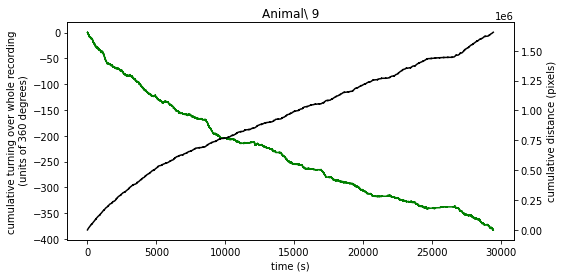

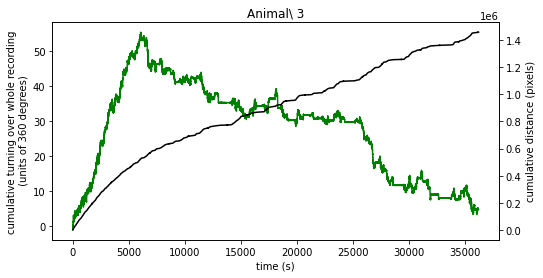

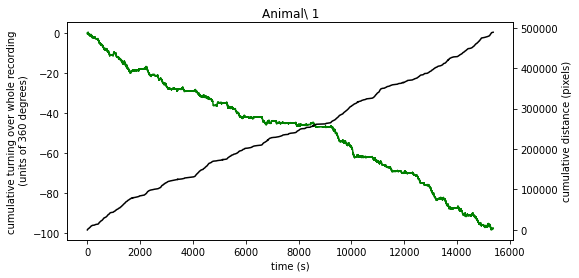

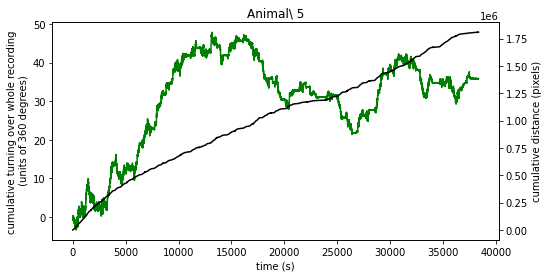

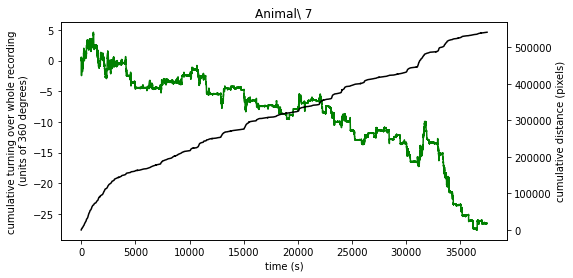

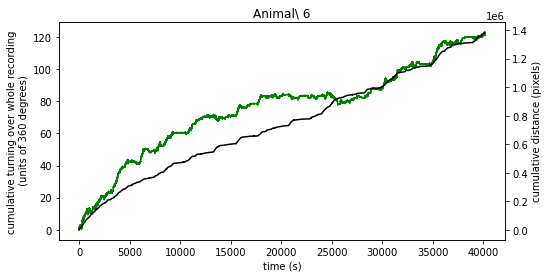

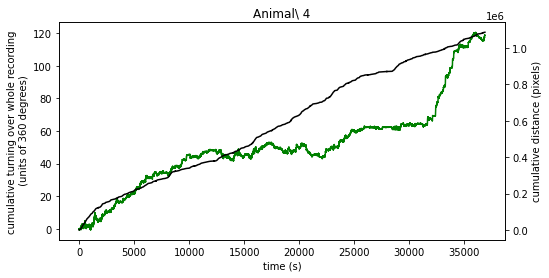

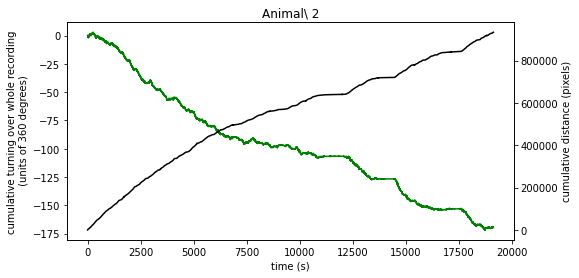

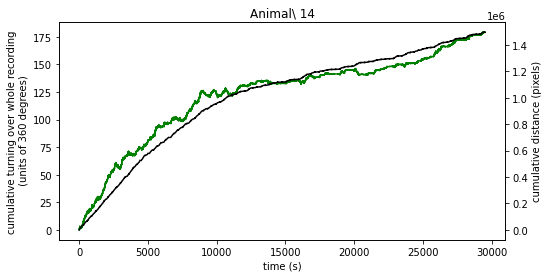

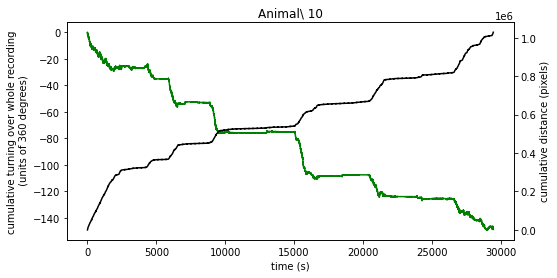

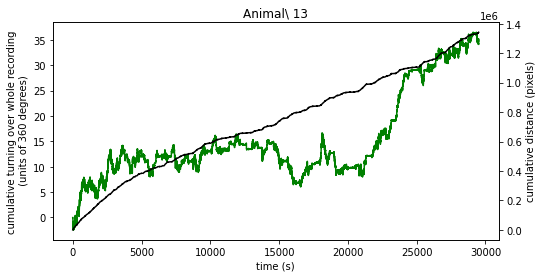

In [61]:
for key in datasets.keys():
    plot_angles_and_distances(key, datasets, save_plots = True)

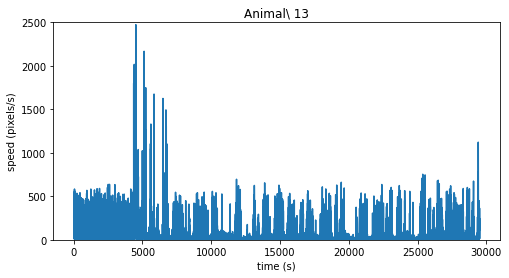

In [72]:
#Create rolling window for speed
#dataset.data.columns
ani_id = 'Animal\ 13'
dataset = datasets[ani_id]
fig, ax = plt.subplots(1, 1, figsize = (8, 4))
n_frames = 10000

plt.plot(dataset.data['total_time'], dataset.data['COM_speed'].rolling(10).mean())
plt.xlabel('time (s)')
plt.ylabel('speed (pixels/s)');
plt.ylim([0, 2500])
plt.title(ani_id)
plt.savefig(os.path.join(plt_dir, 'animal_13_speed.png'), dpi = 200)

Text(0.5, 1.0, 'Histogram of speed')

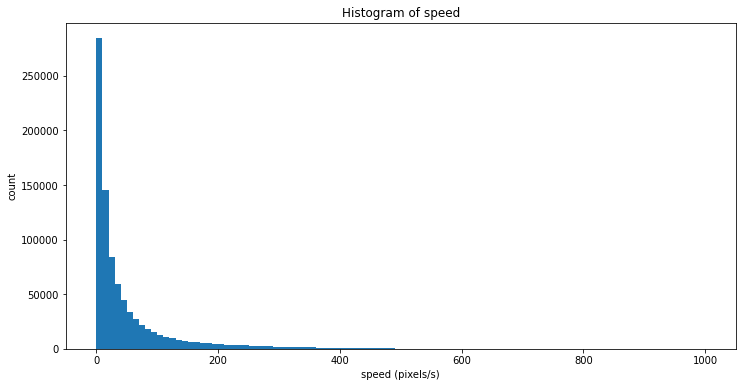

In [83]:
##Histogram of speed
fig, ax = plt.subplots(1, 1, figsize = (12, 6))
plt.hist(dataset.data['COM_speed'], bins = 100, range = (0, 1000))
plt.xlabel('speed (pixels/s)')
plt.ylabel('count')
plt.title('Histogram of speed')


### Plot summaries of all recs

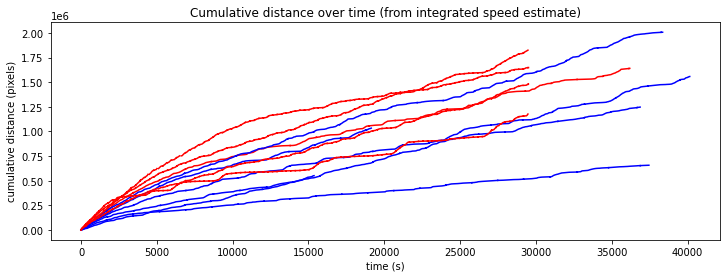

In [58]:
#Create rolling window for speed
#dataset.data.columns
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
color_key = {'WT': 'red', 'HET': 'blue'}
for key, dataset in datasets.items():
    animal = int(key.split(' ')[1])
    genotype = expt_metadata.loc[expt_metadata['animal_id'] == animal, 'genotype'].values[0]
    plt.plot(dataset.data['total_time'], dataset.data['cum_distance'], color = color_key[genotype])
plt.xlabel('time (s)')
plt.ylabel('cumulative distance (pixels)')
plt.title('Cumulative distance over time (from integrated speed estimate)')
plt.savefig(os.path.join(plt_dir, 'cum_distance_over_time.png'), dpi = 200)


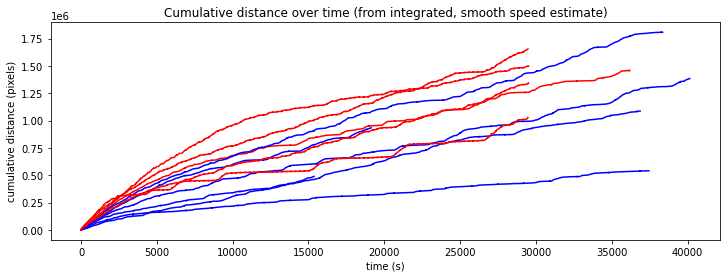

In [57]:
#Create rolling window for speed
#dataset.data.columns
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
color_key = {'WT': 'red', 'HET': 'blue'}
for key, dataset in datasets.items():
    animal = int(key.split(' ')[1])
    genotype = expt_metadata.loc[expt_metadata['animal_id'] == animal, 'genotype'].values[0]
    plt.plot(dataset.data['total_time'], dataset.data['cum_distance_rolling_mean'], color = color_key[genotype])
plt.xlabel('time (s)')
plt.ylabel('cumulative distance (pixels)')
plt.title('Cumulative distance over time (from integrated, smooth speed estimate)');
plt.savefig(os.path.join(plt_dir, 'cum_distance_over_time_smoothed.png'), dpi = 200)

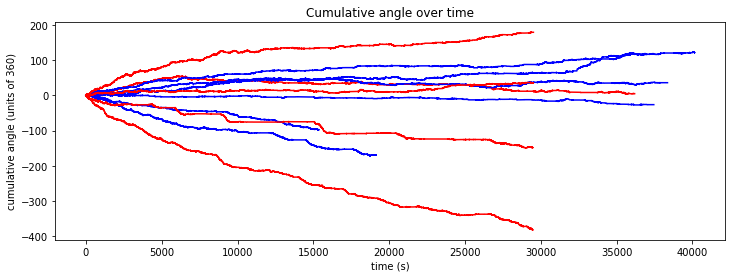

In [56]:
#Create rolling window for speed
#dataset.data.columns
fig, ax = plt.subplots(1, 1, figsize = (12, 4))
color_key = {'WT': 'red', 'HET': 'blue'}
for key, dataset in datasets.items():
    animal = int(key.split(' ')[1])
    genotype = expt_metadata.loc[expt_metadata['animal_id'] == animal, 'genotype'].values[0]
    plt.plot(dataset.data['total_time'], dataset.data['head_hips_angle_cum']/360, color = color_key[genotype])
plt.xlabel('time (s)')
plt.ylabel('cumulative angle (units of 360)')
plt.title('Cumulative angle over time');
plt.savefig(os.path.join(plt_dir, 'cum_angle_over_time.png'), dpi = 200)